In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
import torch
import pandas as pd
from math import sqrt
import os

import sys

import viz_config

sys.path.append('../..')
# sys.path.append('../')

import optimneuralts
from utils import *
torch.set_default_tensor_type("torch.FloatTensor")

saves_path = '../saves'
# plt.rcParams["font.family"] = "Times Roman"
# \usepackage[varvw]{newtxmath}
# fm = matplotlib.font_manager.json_load("/home/quoding/.cache/matplotlib/fontlist-v330.json")
# print(fm.findfont("serif", rebuild_if_missing=False))
# print(fm.findfont("serif", fontext="afm", rebuild_if_missing=False))

/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_n_inter(tens1:torch.Tensor, tens2:torch.Tensor):
    set1 = tens1.unique(dim=0).tolist()
    set2 = tens2.unique(dim=0).tolist()
    
    set1 = set([tuple(item) for item in set1])
    set2 = set([tuple(item) for item in set2])

    inter = set1 & set2
    n_inter = len(set1 & set2)
    percent_of_set1_in_set2 = np.float32(n_inter) / np.float32(len(set1))

    return n_inter, percent_of_set1_in_set2

# Select which data to use

## Compare every config for one instance

In [13]:
figsize = viz_config.set_size(332.89723, 0.49)
flag_two = False

l = os.listdir('../saves/')
labels_fn = "instance_difficile"
assert labels_fn in ['instance_facile', 'instance_difficile']
if labels_fn == "instance_difficile":
    instance = lambda s: 'skew0' not in s
elif labels_fn == "instance_facile":
    instance = lambda s: 'skew0' in s

l = [i for i in l if i.startswith("DE_")]
l = [i for i in l if instance(i)]
l = sorted(l)

Ns = [int(i.split('warmup')[1].split('_')[0]) for i in l]
sort_idx = np.argsort(Ns)
Ns = np.array(Ns)[sort_idx]
l = np.array(l)[sort_idx]
experiments = l

# Ns = [int(i.split('warmup')[1].split('_')[0]) for i in l]
# sort_idx = np.argsort(Ns)
datasets = ["_".join(i.split("bs")[0].split("_")[1:-1]) for i in l]
nus = [fr", $\nu = {i.split('expl')[1]}$" if '30000' not in i else '' for i in l]
labels = [fr"$\tau = {Ns[idx]}${nus[idx]}" for idx in list(range(len(datasets)))]

# styles = ['-o.' if "Difficile" in label else '-.' for label in labels]
styles = ['-' for label in labels]
colors = np.array(["tab:orange", "tab:purple", "tab:green", "tab:red", "tab:cyan", "tab:brown", "tab:pink"])[sort_idx]
print(labels)
print(colors)
print(experiments)
print(datasets) 
interval = 200
upper_lim = 30100

['$\\tau = 1000$, $\\nu = 1$', '$\\tau = 1000$, $\\nu = 10$', '$\\tau = 10000$, $\\nu = 1$', '$\\tau = 10000$, $\\nu = 10$', '$\\tau = 20000$, $\\nu = 1$', '$\\tau = 20000$, $\\nu = 10$', '$\\tau = 30000$']
['tab:green' 'tab:red' 'tab:orange' 'tab:purple' 'tab:cyan' 'tab:brown'
 'tab:pink']
['DE_500_rx_100000_combis_10_patterns_23_bs64_warmup1000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1'
 'DE_500_rx_100000_combis_10_patterns_23_bs64_warmup1000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl10'
 'DE_500_rx_100000_combis_10_patterns_23_bs64_warmup10000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1'
 'DE_500_rx_100000_combis_10_patterns_23_bs64_warmup10000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl10'
 'DE_500_rx_100000_combis_10_patterns_23

## Compare 2 configs on 2 instances

In [3]:
# figsize = viz_config.set_size(300)
figsize = None
flag_two = True
experiments = ['DE_500_rx_100000_combis_10_patterns_23_bs64_warmup10000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1', 'DE_500_rx_100000_combis_10_patterns_skew0_35_bs64_warmup10000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl1']
Ns = [10000, 10000]
datasets = ['500_rx_100000_combis_10_patterns_23', '500_rx_100000_combis_10_patterns_skew0_35']
labels = ['Neutral', 'Protective']
colors = ["tab:orange", "tab:purple"]
styles = ['-' for label in labels]

labels_fn = "vs"
interval = 200
upper_lim = 30100

plt.rcParams['text.latex.preamble'] = r"""\usepackage{type1cm}
\usepackage{newtxtext}
\usepackage[varvw]{newtxmath}"""

# Load data

In [4]:
prefix = "english_prez"
n_trials = 30000
n_runs = 25
metrics_dict = {}
metrics = [
    "recalls",
    "recalls_alls",
    "precisions_alls",
    "precisions",
    "ratio_found_pats",
    "ratio_found_pats_alls",
    "losses",
    "dataset_losses",
    "n_inter_alls",
    "all_flagged_risks",
    "agents",
    "all_flagged_combis_idx",
]
metric_to_ylabel = {}
for exp in experiments:
    metrics_dict[exp] = {}
    for metric in metrics:
        metrics_dict[exp][metric] = []
        for run in range(n_runs):
            path = f"{saves_path}/{exp}/{metric}/{run}.pth"
            metrics_dict[exp][metric].append(torch.load(path, map_location=torch.device("cpu")))

        if "english" not in prefix:
            # Do metrics to ylabel dict
            if 'recall' in metric:
                metric_to_ylabel[metric] = "Rappel"
            elif 'precision' in metric:
                metric_to_ylabel[metric] = "Précision"
            elif 'ratio_found_pats' in metric:
                metric_to_ylabel[metric] = "Ratio $\mathcal{P}$"
            elif 'losses' in metric:
                metric_to_ylabel[metric] = "Perte"
        else:
            # Do metrics to ylabel dict
            if 'recall' in metric:
                metric_to_ylabel[metric] = "Recall"
            elif 'precision' in metric:
                metric_to_ylabel[metric] = "Precision"
            elif 'ratio_found_pats' in metric:
                metric_to_ylabel[metric] = "Ratio $\mathcal{P}$"
            elif 'losses' in metric:
                metric_to_ylabel[metric] = "Loss"

Text(0.5, 1.0, 'ratio $\\mathcal{P}$')

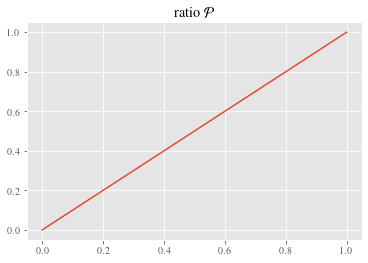

In [30]:
# for i in range(25):
#     name = f'../saves/DE_500_rx_100000_combis_10_patterns_skew0_35_bs64_warmup10000_nmembers32_valnoval_ldsFalse_trainevery10_patience100_usedecay_lrplateau_layers1_withnoise_exactdecay_expl10/dataset_losses/{i}.pth'
#     a = torch.load(name)
#     torch.save(a[:100], name)

/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


recall [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.00048031        nan        nan
 0.00096061        nan        nan 0.00048031        nan 0.00048031
 0.00048031 0.00096061 0.00072046 0.00057637 0.00053367 0.00056036
 0.00067243 0.00067243 0.00048031 0.00053367 0.00076049 0.00070445
 0.00065185 0.00118476 0.00072046 0.00080894 0.00098589 0.00102466
 0.00113014 0.0012488  0.00122745 0.00124315 0.0019441  0.0012488
 0.00170776 0.00133651 0.00864553 0.00136888 0.00130993 0.00155008
 0.00190035 0.0146894  0.00220505 0.00204653 0.00308197 0.02050704
 0.00324688 0.02245437 0.05298751 0.0043828  0.00279831 0.00206132
 0.00314201 0.01667067 0.023439   0.00307397 0.00284182 0.00397695
 0.00804515 0.00450288 0.02837656 0.03191162 0.0290682  0.02693564
 0.04247588 0.0492115  0.00560999 0.04924111 0.00928594 0.01317963
 0.03976945 0.12785783 0.05483509 0.08021134 0.11550432 

/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


recall [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan 4.80307397e-04
 4.80307397e-04 4.80307397e-04 7.20461095e-04 7.20461095e-04
 7.20461095e-04 6.00384246e-04 6.00384246e-04 5.76368876e-04
 5.48922739e-04 6.00384246e-04 6.40409862e-04 6.98628941e-04
 7.20461095e-04 7.20461095e-04 8.84776783e-04 9.12584054e-04
 9.37743013e-04 1.04414651e-03 1.25297582e-03 1.52445391e-03
 1.71240028e-03 2.15094182e-03 2.28146013e-03 2.53602305e-03
 2.95869356e-03 3.32372719e-03 3.80403458e-03 4.51488953e-03
 5.05283381e-03 5.59077810e-03 6.57060519e-03 7.28146013e-03
 8.16522574e-03 8.91450528e-03 1.59269933e-02 1.65994236e-02
 1.72718540e-02 1.81940442e-02 1.93659942e-02 3.23150817e-02
 3.34486071e-02 3.45052834e-02 3.58309318e-02 5.29682997e-02
 5.49855908e-02 7.45437080e-02 1.22574448e-01 1.24476465e-01
 1.25994236e-01 1

/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


precision [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99       0.992      0.99333333
 0.995      0.99636364 0.99666667 0.99714286 0.99733333 0.99733333
 0.9964031  0.99673797 0.99500345 0.99503968 0.99471643 0.99507143
 0.99540344 0.99558784 0.99452451 0.99221324 0.992732   0.9931521
 0.9924247  0.99318147 0.99361357 0.99416508 0.99448466 0.99419091
 0.9944213  0.99469403 0.99562887 0.99580016 0.99540925 0.99559409
 0.99579715 0.99621031 0.99640546 0.9969266  0.99696601 0.9970226
 0.99714938 0.99747269 0.99755833 0.99787309 0.99794026 0.99799673
 0.99795382 0.99805141 0.99793775 0.99799971 0.99802539 0.99807319
 0.99813188 0.99815

/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_52805/2790508806.py:17: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)
/home/quoding/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


precision [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 1.                nan        nan
 1.                nan        nan 1.                nan 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.98245614 1.         1.
 1.         1.         1.         1.         1.         1.
 0.99305556 1.         0.97727273 1.         0.98863636 1.
 1.         0.999935   0.99242424 0.98695652 1.         0.98935911
 0.995      0.99648552 0.98541827 1.         0.99516908 0.97596154
 0.99305556 0.9939891  0.99996283 1.         0.99159664 0.98666667
 1.         1.         0.99238332 0.99717498 0.99405813 0.99552189
 0.99718217 0.99992399 0.99370851 0.99993196 0.99754902 0.99702345
 0.99493548 0.9931777  0.98986367 0.99683077 0.99988675 0.99863301
 0.99991747 0.99986128 0.9970483 

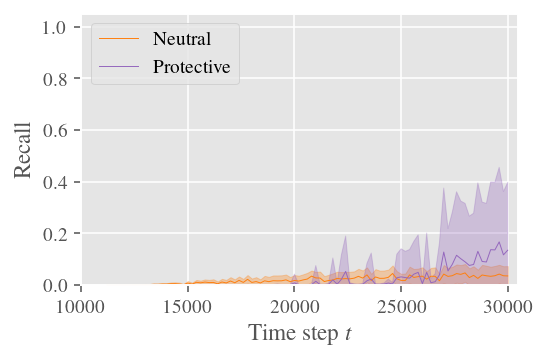

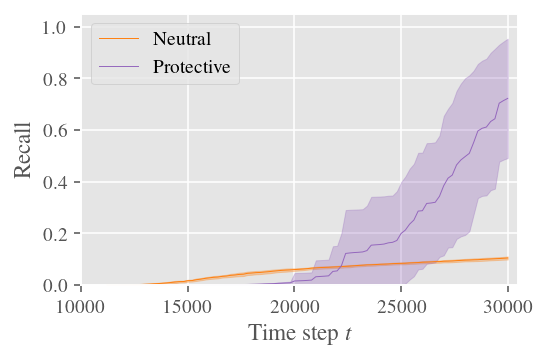

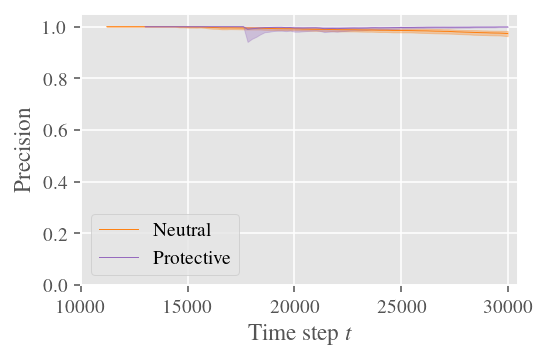

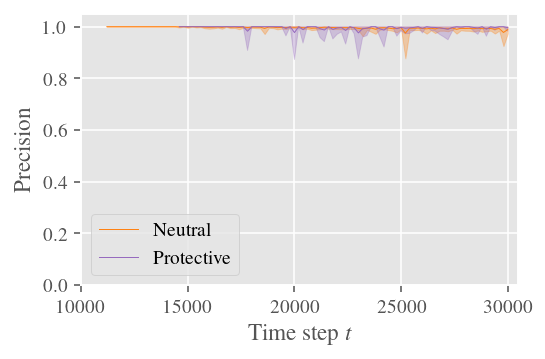

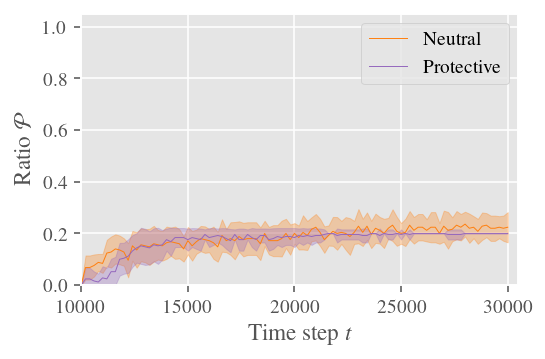

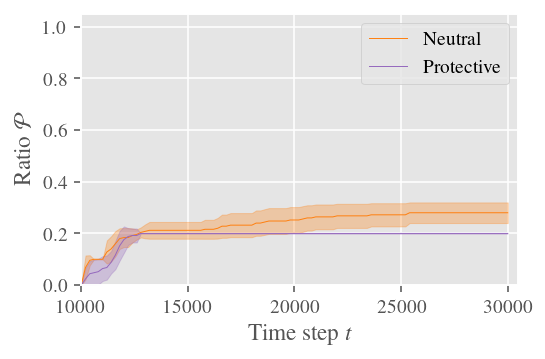

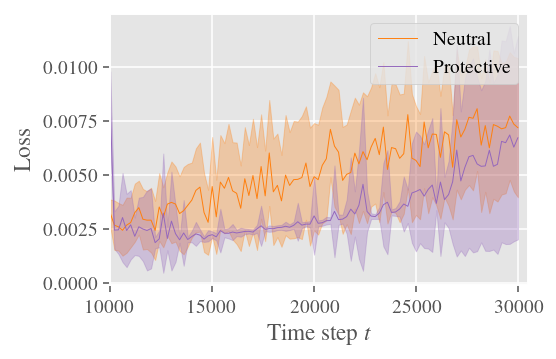

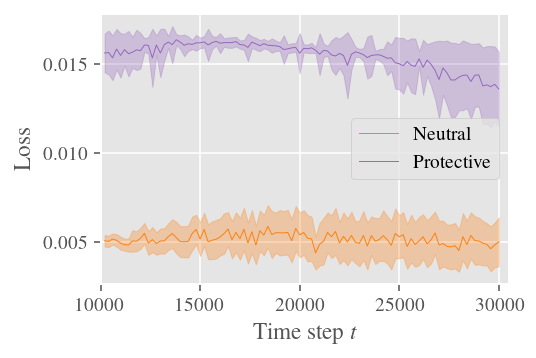

In [12]:
# plt.rcParams["figure.figsize"] = (4,2.666)
# plt.rcParams['figure.dpi'] = 140
metrics_to_eval = [
    "recalls",
    "recalls_alls",
    "precisions_alls",
    "precisions",
    "ratio_found_pats",
    "ratio_found_pats_alls",
    "losses",
    "dataset_losses",
]

for metric in metrics_to_eval:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, exp in enumerate(list(metrics_dict.keys())):
        means = np.nanmean(metrics_dict[exp][metric], axis=0)
        stds = np.nanstd(metrics_dict[exp][metric], axis=0)
        x = np.arange(len(means)) * interval + Ns[i]
        if Ns[i] != 30000:
            if metric == 'dataset_losses': # Usually dataset loss is monitored during agent rollouts, not before.
                x += interval
            ax.plot(x, means, styles[i], color=colors[i], label=labels[i], linewidth=0.5)

        else:
            means = [0] if np.isnan(means) else means
            ax.scatter(x, means, color=colors[i], label=labels[i], s=8)
        ax.fill_between(
            x,
            np.clip(means - stds, 0, 1),
            np.clip(means + stds, 0, 1),
            color=colors[i],
            alpha=0.3,
        )

    ax.set_ylabel(metric_to_ylabel[metric])
    # ax.set_xlabel("Pas de temps $t$")
    ax.set_xlabel("Time step $t$")
    ax.set_xlim(10000, 30500)

    # todo For springer format can delete after
    if 'recalls' in metric:
        ax.set_ylim(0, 1.05)
        ax.legend(loc='upper left')
        print('recall', means, np.nanmin(means), np.nanmax(means))

    elif "precisions" in metric:
        ax.set_ylim(0, 1.05)
        ax.legend(loc='lower left')
        print('precision', means, np.nanmin(means), np.nanmax(means))
    elif 'pat' in metric:
        ax.set_ylim(0, 1.05)
        ax.legend()
    else:
        ax.legend()

    fig.tight_layout()

    # fig.savefig(
    #     f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}.pdf",bbox_inches='tight',pad_inches = 0, format="pdf"
    # )
    
    fig.savefig(
        f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}.png",bbox_inches='tight',pad_inches = 0
    )
    # if "precision" in metric:
    #     ax.set_ylim(0.9, 1.01)
    #     ax.set_xlim(25000, 30500)

    #     fig.savefig(
    #     f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}_zoomed.pdf", format="pdf"
    # )


In [13]:
handles, labels = ax.get_legend_handles_labels()
figsize_leg = viz_config.set_size(332.89723, 0.49)
leg = plt.figure("legend", figsize=figsize_leg)
leg.legend(handles, labels, loc='center')
# leg.show()
leg.savefig('images/polypharmacy/perf/legend.pdf', format='pdf')


<Figure size 162.51x100.437 with 0 Axes>

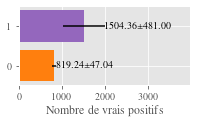

In [42]:
# Plot ratio found pat
metric = "n_inter_alls"
n_inter_means = []
n_inter_stds = []

for i, exp in enumerate(experiments):
    n_inters = []
    for j in range(n_runs):
        n_inters.append(metrics_dict[exp][metric][j][-1])

    n_inters = np.array(n_inters)
    mean = np.nanmean(n_inters)
    n_inter_means.append(mean)
    n_inter_std = np.nanstd(n_inters)
    n_inter_stds.append(n_inter_std)

fig, ax = plt.subplots(figsize=figsize)

p1 = ax.barh(list(range(len(labels))), n_inter_means, xerr=n_inter_stds, color=colors)

n_inter_means = np.array(n_inter_means)
n_inter_stds = np.array(n_inter_stds)
ymax = max(n_inter_means + n_inter_stds)
ax.set_xlim(0, ymax + ymax )

# plt.xlabel('Graine aleatoire')
# ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_xlabel("Nombre de vrais positifs")
ax.bar_label(p1, labels=[f"${m:.2f}$" + "$\pm$" + f"${s:.2f}$" for m, s in zip(n_inter_means, n_inter_stds)])
# ax.bar_label(p1, labels=[f"${m:.2f}$" + "\n" + "$\pm$" + "\n" +f"${s:.2f}$" for m, s in zip(n_inter_means, n_inter_stds)])
plt.tight_layout()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}.pdf', format="pdf")


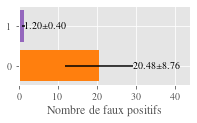

In [43]:
# Plot ratio found pat
metric = "all_flagged_risks"
thresh = 1.1
means = []
stds = []
for i, exp in enumerate(experiments):
    n_flagged_below_thresh = []
    for j in range(n_runs):
        # n_total_flagged = sum(metrics_dict[exp][metric][j])
        if metrics_dict[exp][metric][j].nelement() == 0:
            continue
        n = sum(metrics_dict[exp][metric][j] < thresh)
        n_flagged_below_thresh.append(n.item())

    seeds = np.arange(len(n_flagged_below_thresh))
    n_flagged_below_thresh = np.array(n_flagged_below_thresh)
    mean = np.nanmean(n_flagged_below_thresh)
    std = np.nanstd(n_flagged_below_thresh)
    if np.isnan(mean):
        mean = 0
    if np.isnan(std):
        std = 0
    means.append(mean)
    stds.append(std)



fig, ax = plt.subplots(figsize=figsize)

means = np.array(means)
stds = np.array(stds)
ymax = max(means + stds)
ax.set_xlim(0, ymax + ymax / 2)


p1 = ax.barh(list(range(len(labels))), means, xerr=stds, color=colors)
# plt.xlabel('Graine aleatoire')
# ax.set_xticks(list(range(len(labels))), labels=labels)
ax.set_xlabel("Nombre de faux positifs")
# bar_labels = [f"${m:.2f} \pm {s:.2f}$" for m, s in zip(means, stds)]
ax.bar_label(p1, labels=[f"${m:.2f}$" + "$\pm$" + f"${s:.2f}$" for m, s in zip(means, stds)])
plt.tight_layout()
plt.yticks()
plt.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}_fauxpos.pdf", format="pdf")


In [23]:
def color_and_label_violinplot(violin, color, label):
    for pc in violin['bodies']:
        pc.set_color(color)

    violin["cbars"].set_color(color)
    # violin["cmeans"].set_color(color)
    violin["cmins"].set_color(color)
    violin["cmaxes"].set_color(color)
    
    fig_labels.append((mpatches.Patch(color=color), label))


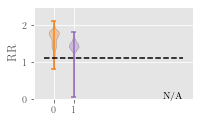

In [11]:
# Plot ratio found pat
fig_labels = []
metric = "all_flagged_risks"
all_flagged_risks_indiv = []
plt.figure(figsize=figsize)
for i, exp in enumerate(experiments):
    all_flagged_risks_this_exp = []
    for j in range(n_runs):
        all_flagged_risks_this_exp.extend(metrics_dict[exp][metric][j].flatten().tolist())
    if not all_flagged_risks_this_exp:
        # if list is empty, place 2 nans in it
        all_flagged_risks_this_exp = [np.nan, np.nan]
    all_flagged_risks_indiv.append(all_flagged_risks_this_exp)


violin_plot = plt.violinplot(all_flagged_risks_indiv)
for i, pc in enumerate(violin_plot["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
violin_plot["cbars"].set_color(colors)
violin_plot["cmins"].set_color(colors)
violin_plot["cmaxes"].set_color(colors)

plt.text(6.5, 0, "N/A")
# plt.text(6.5, 0.8, "N/A")
plt.ylim(0, 2.5)
plt.plot([0.5, 7.5], [1.1, 1.1], linestyle='dashed', color='black')
plt.xticks(np.arange(1, len(labels) + 1), labels=np.arange(0, len(labels)))
plt.ylabel("RR")
plt.xlim(0, 8)
plt.tight_layout()
plt.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_where_flagged_{labels_fn}.pdf", format="pdf")


[0.2354312539100647, 0.2523474097251892, 0.26096999645233154, 0.2362385392189026, 0.22345679998397827, 0.22911053895950317, 0.24014335870742798, 0.252821683883667, 0.24770641326904297, 0.2340967059135437, 0.23314285278320312, 0.2666666507720947, 0.24384784698486328, 0.25201380252838135, 0.24390244483947754, 0.284030020236969, 0.20927155017852783, 0.23638778924942017, 0.20588237047195435, 0.25058549642562866, 0.23903000354766846, 0.23076921701431274, 0.238095223903656, 0.23310810327529907, 0.24720358848571777]
[0.38329386711120605, 0.377322256565094, 0.3575221300125122, 0.5026738047599792, 0.4050464630126953, 0.3715696930885315, 0.3684210777282715, 0.38067179918289185, 0.501672238111496, 0.3794347643852234, 0.37945878505706787, 0.39624786376953125, 0.3588390350341797, 0.35784316062927246, 0.3787878751754761, 0.3718593120574951, 0.35092347860336304, 0.47608697414398193, 0.4627976417541504, 0.3481246829032898, 0.3623426556587219, 0.3416351079940796, 0.3769230842590332, 0.3515831232070923,

<Figure size 560x373.24 with 0 Axes>

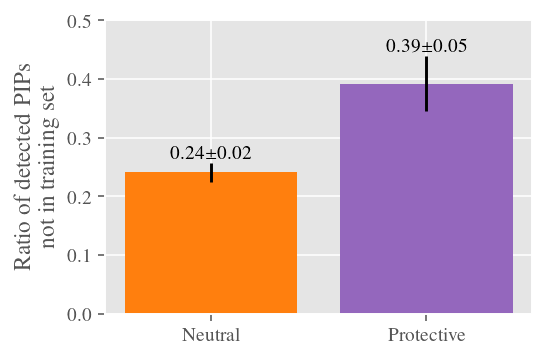

In [16]:
plt.clf()
metric = "all_flagged_combis_idx"
means, stds = [], []
for i, exp in enumerate(experiments):
    n_inter, percent_of_flagged_notin_train = [], []
    combis, risks, pat_vecs, n_obs, n_dim = load_dataset(
        datasets[i], path_to_dataset="../datasets"
    )
    for j in range(n_runs):
        all_flagged_combis_idx = list(metrics_dict[exp][metric][j])
        all_flagged_combis = combis[all_flagged_combis_idx]
        training_set = metrics_dict[exp]["agents"][j].train_dataset.features
        inter, percent = compute_n_inter(all_flagged_combis, training_set)
        percent = 1 - percent
        n_inter.append(inter)
        percent_of_flagged_notin_train.append(percent)

        if np.isnan(percent_of_flagged_notin_train).all():
            percent_of_flagged_notin_train = [0]
    print(percent_of_flagged_notin_train)
    means.append(np.nanmean(percent_of_flagged_notin_train))
    stds.append(np.nanstd(percent_of_flagged_notin_train))

fig, ax = plt.subplots(figsize=figsize)
print(means)
means = np.array(means)
stds = np.array(stds)
ymax = max(means + stds)
if not flag_two:
    p1 = ax.barh(list(range(len(labels))), means, xerr=stds, color=colors)
    ax.set_xlabel(r"Ratio $\not\in\mathcal{D}_T$")
    ax.set_xlim(0, 1.2)

else:
    p1 = ax.bar(list(range(len(labels))), means, yerr=stds, color=colors)
    ax.set_xticks(list(range(len(labels))), labels=labels)
    # ax.set_ylabel(r"Ratio $\not\in\mathcal{D}_T$")
    ax.set_ylabel("Ratio of detected PIPs\nnot in training set")
    ax.set_ylim(0, 0.5)


ax.bar_label(p1, labels=[f"${m:.2f}$" + "$\pm$"  +f"${s:.2f}$" if m != 0 else 'N/A' for m, s in zip(means, stds)])

plt.tight_layout()
# plt.savefig(
#     f"images/polypharmacy/perf/{prefix}_can_we_use_replay_buffer_to_flag_{labels_fn}.pdf",bbox_inches='tight',pad_inches = 0, format="pdf"
# )
plt.savefig(
    f"images/polypharmacy/perf/{prefix}_can_we_use_replay_buffer_to_flag_{labels_fn}.png",bbox_inches='tight',pad_inches = 0
)
